<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

Можно делать onehot encoding для букв, затем делать свертки на последовательности фиксированной длины (это и будет решение для неогр. длины входа). Проблема в том, что мы не учитываем последовательность букв. Можно использовать n-граммы, но это сильно увеличивает и без того немаленький датасет + по большому счету это эвристика/костыль.

**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

Ключевая особенность LSTM в том, что она может дольше сохранять информацию о прошлом, как следствие, лучше выучивает грамматику. Из минусов -- градиенты могут 'взорваться'.

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?

<Ответ>

**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?

<Ответ>


**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

<Ответ>

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

<Ответ>

* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline. It can help u https://ars-ashuha.ru/slides/2016.11.11_ImageCaptioning/image_captionong.pdf 

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [1]:
# !wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
# !tar -xvzf data.tar.gz

### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 2.65 s, sys: 604 ms, total: 3.25 s
Wall time: 3.18 s


In [3]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [5]:
from collections import defaultdict

In [6]:
# Build a Vocabulary

word_counts = defaultdict(int)
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        for word in captions[img_i][caption_i]:
            word_counts[word] += 1

In [7]:
word_counts['#END#']

616767

In [8]:
vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [9]:
n_tokens

10373

In [10]:
word_to_index['#END#']

8134

In [11]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [12]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,  3980,  6254,  8134,    -1,    -1],
       [ 8481,  6766,  1243,  8902,  1021,  9095,  6254,  3980,  8256,
          727,  5915,  8134,    -1,    -1,    -1],
       [ 8481,  8717,  4136, 10058,  9934,  5915,  4859,  6766,  5627,
         8639,   535,  5470,  7115,  5155,  8134],
       [ 8481,  8717,  8897,  3069,  2538,   781,  8717,  8897,  1558,
         8134,    -1,    -1,    -1,    -1,    -1],
       [ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,   535,  5470,  8919,  8134,    -1]], dtype=int32)

### Mah Neural Network

In [13]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 1024 #pls change me if u want
LSTM_UNITS = 1024 #pls change me if u want

In [14]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

/home/igor/anaconda2/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6020 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:04.0)


In [15]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [16]:
#network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

#embeddings for words 
l_word_embeddings = EmbeddingLayer(l_words, len(vocab), EMBED_SIZE)

In [17]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
# l_image_features_small = <Apply Dropout Layer to regularise your Net>
l_image_features_small = DropoutLayer(l_image_features, p=0.5)
# l_image_features_small = <Apply Dense to acive LSTM_UNITS size of representation>
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)
assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [18]:
grad_clip = 300

In [19]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=grad_clip)

In [20]:
# !pip install --upgrade https://github.com/yandexdataschool/AgentNet/archive/master.zip

In [21]:
# Decoding of rnn hiden states
# http://agentnet.readthedocs.io/en/master/user/install.html
# !./install_agentnet.sh
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 1024)
output shape =  (None, None, 10373)


In [22]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
# loss = <mean over non-PAD tokens>
# loss = loss[output_mask].mean()
loss = (loss * output_mask).sum() / output_mask.sum()

In [23]:
sh_lr = theano.shared(lasagne.utils.floatX(0.1))

In [24]:
#trainable NN weights
weights = lasagne.layers.get_all_params(predicted_probabilities, trainable=True)
updates = lasagne.updates.momentum(loss,
                                   weights,
                                   learning_rate=sh_lr,
                                   momentum=0.9)

In [25]:
print(weights)

[W, W, b, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W, b]


In [26]:
%%time
# compile a function that takes input sentence and image mask, outputs loss and updates weights
# please note that your functions must accept image features as FIRST param and sentences as second one

train_step = theano.function([image_vectors, sentences],
                             loss,
                             updates=updates,
                             allow_input_downcast=True)

/home/igor/anaconda2/lib/python2.7/site-packages/theano/tensor/basic.py:5130: UserWarning: flatten outdim parameter is deprecated, use ndim instead.
  "flatten outdim parameter is deprecated, use ndim instead.")


CPU times: user 8.42 s, sys: 288 ms, total: 8.71 s
Wall time: 8.97 s


In [27]:
%%time
val_step = theano.function([image_vectors, sentences],
                             loss,
                             allow_input_downcast=True)

CPU times: user 1 s, sys: 44 ms, total: 1.04 s
Wall time: 1.02 s


# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [28]:
captions = np.array(captions)

In [29]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [30]:
generate_batch(img_codes, captions, 2)

(array([[ 3.62544203, -1.56417799, -3.54905438, ...,  3.87773108,
          1.80802512,  0.95153117],
        [ 1.77290761,  3.41719007, -1.15940785, ...,  4.89460564,
          5.87758207, -0.56284034]], dtype=float32),
 array([[ 8481,  8717,  5627,  8897,  6714,  5056,   781,  3323,  5395,
          7323,  8134,    -1,    -1,    -1,    -1,    -1],
        [ 8481,  8717,  9934,  7399,   130,  4376, 10058,  7058,   781,
          3976, 10058,  8717,  2748,  4859,   394,  8134]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [31]:
batch_size = 150 #adjust me
n_epochs   = 200 #adjust me
n_batches_per_epoch = 50 #adjust me
n_validation_batches = 10 #how many batches are used for validation after each epoch

In [32]:
# !pip install tqdm

In [33]:
from IPython import display
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
sh_lr = theano.shared(lasagne.utils.floatX(0.1))
train_loss_history = []
test_loss_history = []

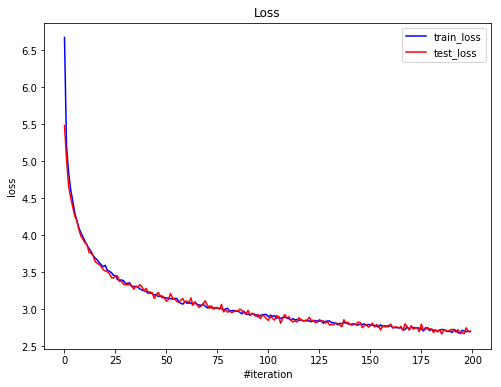


Epoch: 199, train loss: 2.69605680466, val loss: 2.70628049374
('LR: ', array(0.003593699773773551, dtype=float32))

 Decressing LR: 0.00359369977377 -> 0.00118592090439
Finish :)


In [35]:
for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes, captions, batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    
    train_loss_history.append(train_loss)
    test_loss_history.append(val_loss)
    plt.title("Loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(train_loss_history, 'b', label='train_loss')
    plt.plot(test_loss_history, 'r', label='test_loss')
    plt.legend(loc='best')
    plt.show()
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
    print('LR: ', sh_lr.get_value())
    
    try:
        if (epoch + 1) % 50 == 0 or (train_loss_history[-1] - train_loss_history[-2]) > 0.2:
            if sh_lr.get_value < 0.0001:
                if (epoch + 1) % 100 == 0:
                    new_lr = theano.shared(lasagne.utils.floatX(sh_lr.get_value() * 0.66))
            else:
                new_lr = theano.shared(lasagne.utils.floatX(sh_lr.get_value() * 0.33))
            print('\n Decressing LR: {} -> {}'.format(sh_lr.get_value(), new_lr.get_value()))
            if new_lr.get_value() > 10**(-6):
                sh_lr = new_lr
    except Exception as e:
        print("err at changing lr: {}".format(e))
    
print("Finish :)")

In [36]:
# добавим LR
sh_lr = theano.shared(0.002)
n_epochs = 500

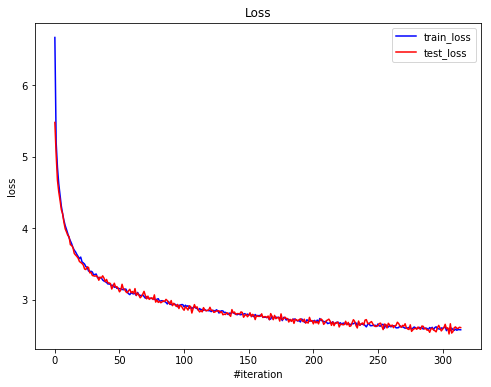

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 114, train loss: 2.57693591595, val loss: 2.6075881958
('LR: ', array(0.0006600000197067857, dtype=float32))


 36%|███▌      | 18/50 [00:09<00:15,  2.12it/s]


KeyboardInterrupt: 

In [37]:
for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes, captions, batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    
    train_loss_history.append(train_loss)
    test_loss_history.append(val_loss)
    plt.title("Loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(train_loss_history, 'b', label='train_loss')
    plt.plot(test_loss_history, 'r', label='test_loss')
    plt.legend(loc='best')
    plt.show()
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
    print('LR: ', sh_lr.get_value())
    
    try:
        if (epoch + 1) % 100 == 0 or (train_loss_history[-1] - train_loss_history[-2]) > 0.1:
            new_lr = theano.shared(lasagne.utils.floatX(sh_lr.get_value() * 0.33))
            print('\n Decressing LR: {} -> {}'.format(sh_lr.get_value(), new_lr.get_value()))
            if new_lr.get_value() > 10**(-4):
                sh_lr = new_lr
    except Exception as e:
        print("err at changing lr: {}".format(e))
    
print("Finish :)")

In [ ]:
for epoch in range(300):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes, captions, batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    
    train_loss_history.append(train_loss)
    test_loss_history.append(val_loss)
    plt.title("Loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(train_loss_history, 'b', label='train_loss')
    plt.plot(test_loss_history, 'r', label='test_loss')
    plt.legend(loc='best')
    plt.show()
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
    print('LR: ', sh_lr.get_value())
    
    try:
        if (epoch + 1) % 100 == 0 or (train_loss_history[-1] - train_loss_history[-2]) > 0.1:
            new_lr = theano.shared(lasagne.utils.floatX(sh_lr.get_value() * 0.33))
            print('\n Decressing LR: {} -> {}'.format(sh_lr.get_value(), new_lr.get_value()))
            if new_lr.get_value() > 10**(-4):
                sh_lr = new_lr
    except Exception as e:
        print("err at changing lr: {}".format(e))
    
print("Finish :)")

### apply trained model

In [46]:
#the same kind you did last week, but a bit smaller
# pip install scikit-image
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [47]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

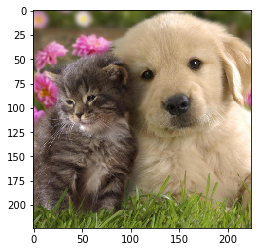

In [48]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

In [49]:
image_features = get_cnn_features(img)
print(len(image_features), len(image_features[0]))

(1, 1000)


## Generate caption

In [50]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=2,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [51]:
for i in range(10):
    print ' '.join(generate_caption(img,t=2., sample=False)[1:-1])

a cat that is sitting on a table
a cat that is standing in the grass
a cat with a cat in its mouth
a small white cat standing on a table
a cat with a white and blue cat on its head
a small white cat with a stuffed animal
a cat that is sitting on a table
a cat is standing on a green chair
a cat that is sitting on a bench
a cat with a cat in its mouth


In [52]:
for i in range(50):
    print ' '.join(generate_caption(img,t=2., sample=True)[1:-1])

a cat is standing in front of a mirror
a close up of a cat looking at a cat
a cat with its eyes in a small cage
a cat standing in front of a table with flowers
a woman is holding a cat near a fake teddy bear
a small white cat with its eyes open
a cat sitting on a table near a window
a small white cat on a wooden floor
a picture of a cat and a cat in the back
a cat sitting on a red and white couch
a small white cat with its head on a table
a cat is sitting in a car that has its paws on the ground
a small baby sitting on a green bench
a cat staring at a bird on a table
a small white cat is laying on a bed
a small white cat standing on a green table
a cat with its head on a green frisbee
a cat sitting on a fence holding a stuffed animal
a fluffy cat sitting in the grass with a stuffed animal
a man holding a stuffed animal in his mouth
a gray and white cat laying next to a stuffed animal
a cat that is looking out of a window
a cat sitting in a group of milk
a woman holding a cat with their

# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# RESNET

In [53]:
# ResNet-50, network from the paper:
# "Deep Residual Learning for Image Recognition"
# http://arxiv.org/pdf/1512.03385v1.pdf
# License: see https://github.com/KaimingHe/deep-residual-networks/blob/master/LICENSE

# Download pretrained weights from:
# https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/resnet50.pkl

import lasagne
from lasagne.layers import InputLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import BatchNormLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import ElemwiseSumLayer
from lasagne.layers import DenseLayer
from lasagne.nonlinearities import rectify, softmax


def build_simple_block(incoming_layer, names,
                       num_filters, filter_size, stride, pad,
                       use_bias=False, nonlin=rectify):
    """Creates stacked Lasagne layers ConvLayer -> BN -> (ReLu)
    Parameters:
    ----------
    incoming_layer : instance of Lasagne layer
        Parent layer
    names : list of string
        Names of the layers in block
    num_filters : int
        Number of filters in convolution layer
    filter_size : int
        Size of filters in convolution layer
    stride : int
        Stride of convolution layer
    pad : int
        Padding of convolution layer
    use_bias : bool
        Whether to use bias in conlovution layer
    nonlin : function
        Nonlinearity type of Nonlinearity layer
    Returns
    -------
    tuple: (net, last_layer_name)
        net : dict
            Dictionary with stacked layers
        last_layer_name : string
            Last layer name
    """
    net = []
    net.append((
            names[0],
            ConvLayer(incoming_layer, num_filters, filter_size, stride, pad,
                      flip_filters=False, nonlinearity=None) if use_bias
            else ConvLayer(incoming_layer, num_filters, filter_size, stride, pad, b=None,
                           flip_filters=False, nonlinearity=None)
        ))

    net.append((
            names[1],
            BatchNormLayer(net[-1][1])
        ))
    if nonlin is not None:
        net.append((
            names[2],
            NonlinearityLayer(net[-1][1], nonlinearity=nonlin)
        ))

    return dict(net), net[-1][0]


def build_residual_block(incoming_layer, ratio_n_filter=1.0, ratio_size=1.0, has_left_branch=False,
                         upscale_factor=4, ix=''):
    """Creates two-branch residual block
    Parameters:
    ----------
    incoming_layer : instance of Lasagne layer
        Parent layer
    ratio_n_filter : float
        Scale factor of filter bank at the input of residual block
    ratio_size : float
        Scale factor of filter size
    has_left_branch : bool
        if True, then left branch contains simple block
    upscale_factor : float
        Scale factor of filter bank at the output of residual block
    ix : int
        Id of residual block
    Returns
    -------
    tuple: (net, last_layer_name)
        net : dict
            Dictionary with stacked layers
        last_layer_name : string
            Last layer name
    """
    simple_block_name_pattern = ['res%s_branch%i%s', 'bn%s_branch%i%s', 'res%s_branch%i%s_relu']

    net = {}

    # right branch
    net_tmp, last_layer_name = build_simple_block(
        incoming_layer, map(lambda s: s % (ix, 2, 'a'), simple_block_name_pattern),
        int(lasagne.layers.get_output_shape(incoming_layer)[1]*ratio_n_filter), 1, int(1.0/ratio_size), 0)
    net.update(net_tmp)

    net_tmp, last_layer_name = build_simple_block(
        net[last_layer_name], map(lambda s: s % (ix, 2, 'b'), simple_block_name_pattern),
        lasagne.layers.get_output_shape(net[last_layer_name])[1], 3, 1, 1)
    net.update(net_tmp)

    net_tmp, last_layer_name = build_simple_block(
        net[last_layer_name], map(lambda s: s % (ix, 2, 'c'), simple_block_name_pattern),
        lasagne.layers.get_output_shape(net[last_layer_name])[1]*upscale_factor, 1, 1, 0,
        nonlin=None)
    net.update(net_tmp)

    right_tail = net[last_layer_name]
    left_tail = incoming_layer

    # left branch
    if has_left_branch:
        net_tmp, last_layer_name = build_simple_block(
            incoming_layer, map(lambda s: s % (ix, 1, ''), simple_block_name_pattern),
            int(lasagne.layers.get_output_shape(incoming_layer)[1]*4*ratio_n_filter), 1, int(1.0/ratio_size), 0,
            nonlin=None)
        net.update(net_tmp)
        left_tail = net[last_layer_name]

    net['res%s' % ix] = ElemwiseSumLayer([left_tail, right_tail], coeffs=1)
    net['res%s_relu' % ix] = NonlinearityLayer(net['res%s' % ix], nonlinearity=rectify)

    return net, 'res%s_relu' % ix


def build_model_resnet():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    sub_net, parent_layer_name = build_simple_block(
        net['input'], ['conv1', 'bn_conv1', 'conv1_relu'],
        64, 7, 2, 3, use_bias=True)
    net.update(sub_net)
    net['pool1'] = PoolLayer(net[parent_layer_name], pool_size=3, stride=2, pad=0, mode='max', ignore_border=False)
    block_size = list('abc')
    parent_layer_name = 'pool1'
    for c in block_size:
        if c == 'a':
            sub_net, parent_layer_name = build_residual_block(net[parent_layer_name], 1, 1, True, 4, ix='2%s' % c)
        else:
            sub_net, parent_layer_name = build_residual_block(net[parent_layer_name], 1.0/4, 1, False, 4, ix='2%s' % c)
        net.update(sub_net)

    block_size = list('abcd')
    for c in block_size:
        if c == 'a':
            sub_net, parent_layer_name = build_residual_block(
                net[parent_layer_name], 1.0/2, 1.0/2, True, 4, ix='3%s' % c)
        else:
            sub_net, parent_layer_name = build_residual_block(net[parent_layer_name], 1.0/4, 1, False, 4, ix='3%s' % c)
        net.update(sub_net)

    block_size = list('abcdef')
    for c in block_size:
        if c == 'a':
            sub_net, parent_layer_name = build_residual_block(
                net[parent_layer_name], 1.0/2, 1.0/2, True, 4, ix='4%s' % c)
        else:
            sub_net, parent_layer_name = build_residual_block(net[parent_layer_name], 1.0/4, 1, False, 4, ix='4%s' % c)
        net.update(sub_net)

    block_size = list('abc')
    for c in block_size:
        if c == 'a':
            sub_net, parent_layer_name = build_residual_block(
                net[parent_layer_name], 1.0/2, 1.0/2, True, 4, ix='5%s' % c)
        else:
            sub_net, parent_layer_name = build_residual_block(net[parent_layer_name], 1.0/4, 1, False, 4, ix='5%s' % c)
        net.update(sub_net)
    net['pool5'] = PoolLayer(net[parent_layer_name], pool_size=7, stride=1, pad=0,
                             mode='average_exc_pad', ignore_border=False)
    net['fc1000'] = DenseLayer(net['pool5'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc1000'], nonlinearity=softmax)

    return net

In [54]:
# !wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/resnet50.pkl -O resnet50.pkl

In [55]:
resnet50 = build_model_resnet()

In [56]:
resnet50_weights = pickle.load(open('resnet50.pkl'))['values']
set_all_param_values(resnet50['prob'], resnet50_weights)

In [57]:
#compile get_features
cnn_input_var = resnet50['input'].input_var
cnn_feature_layer_resnet = resnet50['fc1000']
get_cnn_features_by_resnet50 = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer_resnet))

In [58]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=2,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [59]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=2,sample=True,max_len=100):
    image_features = get_cnn_features_by_resnet50(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [60]:
for i in range(10):
    print ' '.join(generate_caption(img,t=2., sample=True)[1:-1])

a dog is sitting on the floor with a dog
a dog laying on a blanket on a field
a dog that is looking at his cell phone
a dog standing next to a person holding a frisbee
a dog wearing a hat and a hat
a man is holding a teddy bear
a lady holding a cat in her hand
a dog standing on a couch and a woman
a dog is sitting on a bench next to a teddy bear
a man is holding a large teddy bear


Ей! a dog is sitting on the floor with a dog

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 